# Workflow pipeline

## Import des modules n√©cessaires

In [1]:
import sys
sys.path.append("C:/Users/Fab/Documents/P5_D√©ployez_un_mod√®le_de_Machine_Learning")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, fbeta_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import precision_recall_curve

import joblib

# M√©triques pour la classification
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    confusion_matrix,
    classification_report
)


# XGBoost
from xgboost import XGBClassifier

# CatBoost
from catboost import CatBoostClassifier

# SMOTE
import imblearn
from imblearn.over_sampling import SMOTE

# SHAP
import shap

import warnings
warnings.filterwarnings('ignore')

from app.utils.binary_mapper import BinaryMapper


C:\Users\Fab\AppData\Local\pypoetry\Cache\virtualenvs\p5-d√©ployez-un-mod√®le-de-machine-learning-c3yHBvQq-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chargement du dataset

In [2]:
df_employes_pipe = pd.read_csv('data/employes_net.csv')

In [3]:
df_employes_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 43 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        1470 non-null   int64  
 1   genre                                      1470 non-null   object 
 2   revenu_mensuel                             1470 non-null   int64  
 3   statut_marital                             1470 non-null   object 
 4   departement                                1470 non-null   object 
 5   poste                                      1470 non-null   object 
 6   nombre_experiences_precedentes             1470 non-null   int64  
 7   annee_experience_totale                    1470 non-null   int64  
 8   annees_dans_l_entreprise                   1470 non-null   int64  
 9   annees_dans_le_poste_actuel                1470 non-null   int64  
 10  a_quitte_l_entreprise   

In [4]:
df_employes_pipe["distance_domicile_travail_qcut"] = df_employes_pipe["distance_domicile_travail_qcut"].astype("category")
'''df_employes_pipe["revenu_quartile"] = df_employes_pipe["revenu_quartile"].astype("category")'''

'df_employes_pipe["revenu_quartile"] = df_employes_pipe["revenu_quartile"].astype("category")'

## S√©lection des variables

In [5]:
# Variables num√©riques continues ‚Äì MinMaxScaler
num_MinMax_vars = [
    "revenu_mensuel", 
    "age",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "annes_sous_responsable_actuel",
    "nombre_participation_pee",
    "ratio_stagnation",
    "ratio_sous_responsable",
    "age_revenu",
    "satisfaction_moyenne",
    "interaction_satisfaction_anciennete",
    "taux_de_formation",
    "interaction_distance_heures_sup",
    "surmenage_transports"
]

In [6]:
# Variables cat√©gorielles nominales - OneHotEncoder
cat_nominal_onehot_vars = [
    "statut_marital",
    "departement",
    "poste",
    "domaine_etude",
    "distance_domicile_travail_qcut",
    "tranche_age",
]

In [7]:
# Variables cat√©gorielles ordinales num√©riques ‚Äì OrdinalEncoder
cat_ordinal_numeric_vars = [
    "niveau_education",
    "satisfaction_employee_environnement",
    "note_evaluation_precedente",
    "niveau_hierarchique_poste",
    "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso",
    "note_evaluation_actuelle"
]

In [8]:
# Variables cat√©gorielles ordinales texte ‚Äì OrdinalEncoder
cat_ordinal_texte_vars = ["frequence_deplacement"]
'''cat_ordinal_texte_vars = ["frequence_deplacement", "revenu_quartile"]'''

'cat_ordinal_texte_vars = ["frequence_deplacement", "revenu_quartile"]'

In [9]:
# Variables a ransformer en binaire (0/1)
binary_mapping = {
    "genre": {"M":1, "F":0}
}

In [10]:
# Variables d√©j√† binaires 
binary_vars = [
    "heures_supplementaires_binaire"
]

In [11]:
# Variable cible
target_var = "a_quitte_l_entreprise"

In [42]:
df_employes_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 43 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   age                                        1470 non-null   int64   
 1   genre                                      1470 non-null   object  
 2   revenu_mensuel                             1470 non-null   int64   
 3   statut_marital                             1470 non-null   object  
 4   departement                                1470 non-null   object  
 5   poste                                      1470 non-null   object  
 6   nombre_experiences_precedentes             1470 non-null   int64   
 7   annee_experience_totale                    1470 non-null   int64   
 8   annees_dans_l_entreprise                   1470 non-null   int64   
 9   annees_dans_le_poste_actuel                1470 non-null   int64   
 10  a_quitte_l_e

## Split train/test

In [12]:
X = df_employes_pipe.drop(columns=[target_var])
y = df_employes_pipe[target_var]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## D√©finition des sous-pipelines

In [13]:
'''# Cr√©ation d'une classe de transformation pour le genre
class BinaryMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapping=None):
        # mapping doit √™tre un dict : {colonne: {valeur: code, ...}, ...}
        self.mapping = mapping or {} 

    def fit(self, X, y=None):
        return self  # pas d'apprentissage n√©cessaire

    def transform(self, X):
        X_ = X.copy()
        for col, col_map in self.mapping.items():
            X_[col] = X_[col].map(col_map)
        return X_'''

"# Cr√©ation d'une classe de transformation pour le genre\nclass BinaryMapper(BaseEstimator, TransformerMixin):\n    def __init__(self, mapping=None):\n        # mapping doit √™tre un dict : {colonne: {valeur: code, ...}, ...}\n        self.mapping = mapping or {} \n\n    def fit(self, X, y=None):\n        return self  # pas d'apprentissage n√©cessaire\n\n    def transform(self, X):\n        X_ = X.copy()\n        for col, col_map in self.mapping.items():\n            X_[col] = X_[col].map(col_map)\n        return X_"

In [14]:
# On d√©clare les valeurs binaires pour le genre :
binary_mapping = {
    "genre": {"M": 1, "F": 0},
}


In [15]:
# Sous-pipeline de normalisation
normalisation_pipeline = Pipeline([
    ('minmax', MinMaxScaler())
])

# Sous-pipeline de OneHotEncoder
hot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Sous-pipeline OrdinalEncoder sur variables num√©riques ordonn√©es
ordinal_num_pipeline = Pipeline([
    ('ordinal_num', OrdinalEncoder())
])

# Sous-pipeline OrdinalEncoder sur variables textuelles explicitement ordonn√©es
ordinal_texte_pipeline = Pipeline([
    ('ordinal_texte', OrdinalEncoder(categories=[
        ['Aucun', 'Occasionnel', 'Frequent'],
    ]))
])

# Sous-pipeline de binarisation du genre uniquement
binary_pipeline = Pipeline([
    ('binariseur', BinaryMapper(mapping=binary_mapping))
])

# Sous-pipeline 
binary_pass_pipeline = Pipeline([
    ('pass_through', FunctionTransformer(validate=False))
])

## Assemblage avec ColumnTransformer

In [16]:
# Assemblage
preprocessor = ColumnTransformer([
    ('normal', normalisation_pipeline, num_MinMax_vars),
    ('hot', hot_pipeline, cat_nominal_onehot_vars),
    ('ordinal_num', ordinal_num_pipeline, cat_ordinal_numeric_vars),
    ('ordinal_texte', ordinal_texte_pipeline, cat_ordinal_texte_vars),
    ('binary_mapper', binary_pipeline, ["genre"]),
    ('binary_pass', binary_pass_pipeline, binary_vars)
])

## Pipeline complet

### S√©lection des m√©triques et fonction d'affichage des valeurs de m√©triques

### Choix des m√©triques de classification

- **Accuracy** : Pourcentage de pr√©dictions correctes globalement.
- **Pr√©cision** : Parmi les employ√©s pr√©dits comme partants, combien le sont r√©ellement. Important si faux positifs co√ªteux.
- **Rappel** : Parmi les employ√©s partis, combien sont bien d√©tect√©s. Important si faux n√©gatifs co√ªteux.
- **F-beta score** : Combine pr√©cision et rappel avec un poids ajustable selon la priorit√© (par d√©faut beta=1 = F1).
- **Matrice de confusion** : Pour voir le d√©tail des erreurs (Faux Positifs, Faux N√©gatifs).
- **Classification report** : Pour une synth√®se compl√®te des m√©triques par classe.


In [17]:
# StratifiedKFold avec 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
# Dictionnaire pour stocker les scores par mod√®le
resultats_cv = {}

***‚öôÔ∏è D√©marche de comparaison "out of the box" et validation crois√©e***

Avant d'engager une optimisation approfondie des hyperparam√®tres (Grid Search), nous allons comparer plusieurs mod√®les de classification "out of the box".  
Cela signifie que nous les utilisons **avec leurs param√®tres par d√©faut**, sans r√©glage sp√©cifique.  

L'objectif est de :
- Obtenir une **premi√®re mesure neutre de performance**, pour chaque algorithme.
- Identifier rapidement les mod√®les les plus prometteurs.
- V√©rifier la stabilit√© des performances via une validation crois√©e.

Nous avons ainsi mis en place une **validation crois√©e √† 5 folds** sur les donn√©es d'entra√Ænement.  
Pour chaque mod√®le :
- Les donn√©es sont d√©coup√©es en 5 sous-ensembles (folds).
- √Ä chaque it√©ration, le mod√®le est entra√Æn√© sur 4 folds et √©valu√© sur le fold restant.
- Nous calculons 4 m√©triques principales : Accuracy, Pr√©cision, Rappel et F2-score.
- Nous stockons la moyenne et l'√©cart-type de chaque m√©trique.

Cette approche progressive nous permet :
- De comparer objectivement les mod√®les sur une base identique.
- De rep√©rer ceux qui pr√©sentent un potentiel avant le fine-tuning.
- D'√©viter de passer du temps √† optimiser un mod√®le qui serait d√©j√† en difficult√© dans sa version standard.

En r√©sum√©, la validation crois√©e "out of the box" constitue un **premier filtre exploratoire** avant de lancer la recherche approfondie des meilleurs hyperparam√®tres.


In [19]:
modeles = {
    "Mod√®le Dummy": DummyClassifier(strategy="most_frequent"),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "Regression Logistique": LogisticRegression(random_state=42),
    "XGBoost Classifier": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    "CatBoost Classifier": CatBoostClassifier(
        verbose=0,   # Pas d'affichage des logs pendant le fit. CatBoost affiche par d√©faut beaucoup de logs.Ici on les d√©sactive pour que la boucle reste lisible.
        random_state=42
    )
}

for nom_modele, modele in modeles.items():
    print(f"\n==== Validation crois√©e pour le mod√®le : {nom_modele} ====")
    
    # Initialiser les listes pour stocker les scores
    scores_accuracy = []
    scores_precision = []
    scores_recall = []
    scores_f2 = []
    
    # Boucle sur les folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"\nFold {fold+1}/5")
        
        # S√©parer les donn√©es
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Cr√©er un pipeline propre √† chaque fold        
        pipeline_cv = Pipeline([
            ('preprocessing', preprocessor),
            ('modele_utilise', modele)
        ])
                             
        # Entra√Æner
        pipeline_cv.fit(X_fold_train, y_fold_train)
        
        # Pr√©dire (seuil par d√©faut 0.5)
        y_pred = pipeline_cv.predict(X_fold_val)
        
        # Calculer les m√©triques
        acc = accuracy_score(y_fold_val, y_pred)
        prec = precision_score(y_fold_val, y_pred, zero_division=0)
        rec = recall_score(y_fold_val, y_pred, zero_division=0)
        f2 = fbeta_score(y_fold_val, y_pred, beta=2, zero_division=0)
        
        # Stocker
        scores_accuracy.append(acc)
        scores_precision.append(prec)
        scores_recall.append(rec)
        scores_f2.append(f2)
    
    # R√©sumer
    resultats_cv[nom_modele] = {
        'Accuracy': (np.mean(scores_accuracy), np.std(scores_accuracy)),
        'Precision': (np.mean(scores_precision), np.std(scores_precision)),
        'Recall': (np.mean(scores_recall), np.std(scores_recall)),
        'F2-score': (np.mean(scores_f2), np.std(scores_f2))
    }



==== Validation crois√©e pour le mod√®le : Mod√®le Dummy ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

==== Validation crois√©e pour le mod√®le : Random Forest Classifier ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

==== Validation crois√©e pour le mod√®le : Regression Logistique ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

==== Validation crois√©e pour le mod√®le : XGBoost Classifier ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

==== Validation crois√©e pour le mod√®le : CatBoost Classifier ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5


In [20]:
# Liste pour le dataframe
tableau_resultats = []

for modele, metriques in resultats_cv.items():
    ligne = {
        'Mod√®le': modele,
        'Accuracy (moy ¬± std)': f"{metriques['Accuracy'][0]:.3f} ¬± {metriques['Accuracy'][1]:.3f}",
        'Precision (moy ¬± std)': f"{metriques['Precision'][0]:.3f} ¬± {metriques['Precision'][1]:.3f}",
        'Recall (moy ¬± std)': f"{metriques['Recall'][0]:.3f} ¬± {metriques['Recall'][1]:.3f}",
        'F2-score (moy ¬± std)': f"{metriques['F2-score'][0]:.3f} ¬± {metriques['F2-score'][1]:.3f}"
    }
    tableau_resultats.append(ligne)

df_resultats_cv = pd.DataFrame(tableau_resultats)

In [21]:
df_resultats_cv.head()

Mod√®le Accuracy (moy ¬± std) Precision (moy ¬± std)  \
0              Mod√®le Dummy        0.838 ¬± 0.000         0.000 ¬± 0.000   
1  Random Forest Classifier        0.860 ¬± 0.005         0.739 ¬± 0.099   
2     Regression Logistique        0.878 ¬± 0.014         0.727 ¬± 0.087   
3        XGBoost Classifier        0.866 ¬± 0.011         0.706 ¬± 0.112   
4       CatBoost Classifier        0.874 ¬± 0.003         0.850 ¬± 0.126   

  Recall (moy ¬± std) F2-score (moy ¬± std)  
0      0.000 ¬± 0.000        0.000 ¬± 0.000  
1      0.237 ¬± 0.090        0.269 ¬± 0.092  
2      0.411 ¬± 0.101        0.446 ¬± 0.098  
3      0.332 ¬± 0.064        0.367 ¬± 0.055  
4      0.289 ¬± 0.064        0.330 ¬± 0.064

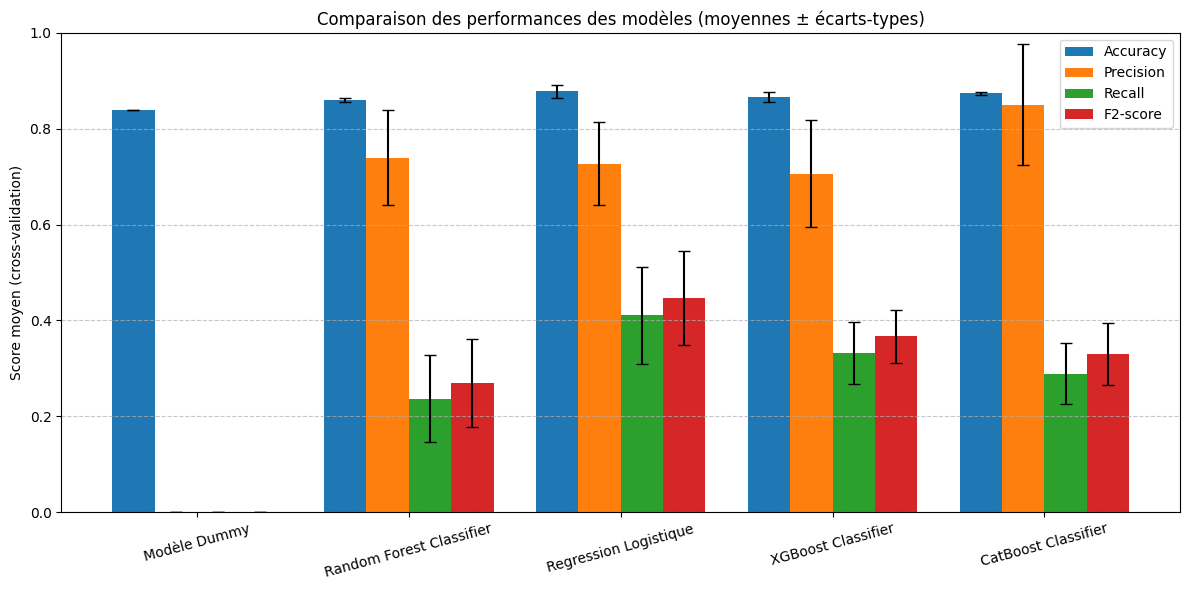

In [22]:
# Liste des mod√®les et des m√©triques
modeles = df_resultats_cv['Mod√®le'].tolist()
metriques = ['Accuracy', 'Precision', 'Recall', 'F2-score']

# Extraction des moyennes et √©carts-types
moyennes = {m: [] for m in metriques}
ecarts = {m: [] for m in metriques}

for m in metriques:
    for i in range(len(df_resultats_cv)):
        # La colonne s'appelle ex: "Accuracy (moy ¬± std)"
        texte = df_resultats_cv.iloc[i][f"{m} (moy ¬± std)"]
        moy, std = texte.split('¬±')
        moyennes[m].append(float(moy.strip()))
        ecarts[m].append(float(std.strip()))

# Param√®tres du graphique
x = np.arange(len(modeles))  # positions des mod√®les
largeur = 0.2  # largeur de chaque barre

# Cr√©ation de la figure
plt.figure(figsize=(12,6))

# Pour chaque m√©trique, cr√©er une s√©rie de barres
for idx, m in enumerate(metriques):
    positions = x + (idx - 1.5)*largeur
    plt.bar(
        positions,
        moyennes[m],
        width=largeur,
        yerr=ecarts[m],
        capsize=4,
        label=m
    )

plt.xticks(x, modeles, rotation=15)
plt.ylim(0,1)
plt.ylabel("Score moyen (cross-validation)")
plt.title("Comparaison des performances des mod√®les (moyennes ¬± √©carts-types)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Nous allons retenir **XGBoostClassifier** car il pr√©sente les meilleures performances parmi les mod√®les non-lin√©aires (exigence du projet)

## Optimisation des hyperparam√®tres

### D√©finition de la grille d'hyperparam√®tres

### üéØ Fine-tuning de XGBoostClassifier : choix des hyperparam√®tres

Pour optimiser notre XGBoostClassifier, nous avons cibl√© **quatre hyperparam√®tres prioritaires**, reconnus comme les plus influents dans la litt√©rature et la pratique‚ÄØ:

- **max_depth** (profondeur maximale des arbres)  
  Permet de moduler la complexit√© du mod√®le.  
  Des valeurs plus √©lev√©es captent plus de d√©tails, mais augmentent le risque de surapprentissage.
  
- **learning_rate** (alias *eta*, taux d‚Äôapprentissage)  
  Contr√¥le l‚Äôamplitude des mises √† jour du mod√®le.  
  Un learning rate faible ralentit l‚Äôapprentissage mais favorise une convergence plus stable.
  
- **subsample**  
  Fraction des √©chantillons utilis√©s par arbre.  
  Introduit une forme de *bagging* qui r√©duit la variance et limite le surapprentissage.  
  Le *bagging* consiste √† entra√Æner plusieurs mod√®les sur des sous-√©chantillons diff√©rents, puis √† agr√©ger leurs pr√©dictions, ce qui stabilise les r√©sultats.
  
- **scale_pos_weight**  
  Coefficient de pond√©ration des observations de la classe minoritaire.  
  Ce param√®tre est particuli√®rement utile dans un contexte de classes d√©s√©quilibr√©es.  
  Il permet d‚Äôindiquer √† l‚Äôalgorithme qu‚Äôune erreur sur la classe positive est plus p√©nalisante.  
  Cela peut am√©liorer le rappel sans recourir syst√©matiquement √† l‚Äôoversampling.
  
Trois de ces quatre param√®tres sont mis en avant comme le **"trio cl√©"** √† optimiser en priorit√©, notamment dans cet [Article source](https://medium.com/%40nekhumbecolbert3/unleashing-the-power-of-catboostclassifier-a-robust-model-for-categorical-feature-handling-a05e7dcf23b2) (Unleashing the Power of CatBoostClassifier: A Robust Model for Categorical Feature Handling de Humbulani Colbert, Medium)

In [23]:
# D√©finition des hyperparam√®tres
param_grid_xgboost = {
    'modele_utilise__max_depth': [3, 6, 9],
    'modele_utilise__learning_rate': [0.1, 0.3, 0.5],
    'modele_utilise__subsample': [0.25, 0.5, 1.0],
    'modele_utilise__scale_pos_weight': [1, 3, 5]
}

##### üîç Raisonnement derri√®re les choix de valeurs

Nous avons appliqu√© une m√©thode raisonn√©e consistant √† explorer, pour chaque hyperparam√®tre, **la valeur par d√©faut et deux variantes contrast√©es** (une plus prudente, une plus ambitieuse).  
Cette approche permet d‚Äôidentifier l‚Äôinfluence des r√©glages sans partir dans un grid trop vaste.

---

##### üìä Hyperparam√®tres de complexit√© et r√©gularisation

| Hyperparam√®tre    | Valeur par d√©faut      | Variante ‚Äú-1‚Äù              | Variante ‚Äú+1‚Äù               |
|-------------------|------------------------|----------------------------|-----------------------------|
| **max_depth**     | 6                      | 3 (mod√®le moins complexe)  | 9 (mod√®le plus complexe)    |
| **learning_rate** | 0.3                    | 0.1 (apprentissage plus r√©gulier) | 0.5 (apprentissage plus rapide) |
| **subsample**     | 1.0                    | 0.5 (bagging plus fort)    | 1.0 (bagging complet)       |

Ces valeurs sont directement inspir√©es des recommandations courantes pour **ma√Ætriser le compromis biais/variance** et tester l‚Äôimpact de la profondeur et de la vitesse d‚Äôapprentissage.

---

##### ‚öñÔ∏è Hyperparam√®tre de pond√©ration des classes

| Hyperparam√®tre         | Valeur par d√©faut | Variante ‚Äú+1‚Äù          | Variante ‚Äú+2‚Äù           |
|------------------------|-------------------|------------------------|-------------------------|
| **scale_pos_weight**   | 1                 | 3 (pond√©ration mod√©r√©e) | 5 (pond√©ration plus forte) |

**Pourquoi cet encadrement diff√©rent ?**

- Contrairement aux autres hyperparam√®tres, `scale_pos_weight` **ne r√©gule pas la complexit√©**, mais **r√©√©quilibre la p√©nalisation des classes dans la fonction de perte**.
- Les bonnes pratiques recommandent de tester plusieurs valeurs sup√©rieures √† 1 lorsque la classe positive est minoritaire.
- M√™me si notre taux de d√©part est ‚âà16‚ÄØ% (et non ultra-d√©s√©quilibr√©), il √©tait pertinent d‚Äôexaminer si une pond√©ration pouvait am√©liorer le rappel.
- Nous avons volontairement choisi des valeurs **uniquement sup√©rieures √† la r√©f√©rence (1)**, car la pond√©ration inf√©rieure n‚Äôa pas de sens pratique ici.

---

**Conclusion**
Cette structuration permet de :
- Conserver un grid limit√© et rationnel.
- S√©parer clairement les param√®tres qui contr√¥lent la complexit√© et ceux qui agissent sur le d√©s√©quilibre.
- Justifier en entretien que chaque hyperparam√®tre a √©t√© r√©fl√©chi en fonction de son r√¥le sp√©cifique.


In [24]:
# Cr√©ation d'un scorer personnalis√© qui calcule le F2-score (pond√®re davantage le rappel) √† chaque fold
f2_scorer = make_scorer(fbeta_score, beta=2)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline complet
# ‚ÄºÔ∏è1er essai scale_pos_weight sans SMOTE
pipeline_XGB_no_smote = Pipeline([
    ('preprocessing', preprocessor),
    ('modele_utilise', XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_XGB_no_smote,
    param_grid=param_grid_xgboost,
    scoring=f2_scorer,
    cv=skf,
    n_jobs=-1,
    verbose=2
)

# Lancement
grid_search.fit(X_train, y_train)

# R√©sultats
print("‚úÖ Meilleurs hyperparam√®tres trouv√©s :")
print(grid_search.best_params_)

print("\n‚úÖ Meilleur F2-score moyen (CV) :")
print(grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
‚úÖ Meilleurs hyperparam√®tres trouv√©s :
{'modele_utilise__learning_rate': 0.1, 'modele_utilise__max_depth': 3, 'modele_utilise__scale_pos_weight': 5, 'modele_utilise__subsample': 0.5}

‚úÖ Meilleur F2-score moyen (CV) :
0.5427304683780967


##### üîç R√©sultats du Grid Search

**Synth√®se des hyperparam√®tres retenus :**

- `learning_rate = 0.1`  
  Le taux d‚Äôapprentissage le plus faible test√©.  
  
- `max_depth = 3`  
  La profondeur minimale parmi les valeurs test√©es.  
  Cela montre qu‚Äôun mod√®le peu complexe suffit √† capturer les patterns principaux, tout en limitant le risque de surapprentissage.
  
- `subsample = 0.25`  
  La fraction la plus r√©duite des √©chantillons par arbre.  
  Ce bagging fort introduit davantage de diversit√© entre les arbres.
  
- `scale_pos_weight = 5`  
  La pond√©ration maximale explor√©e pour la classe minoritaire.  
  Cela confirme que renforcer l‚Äôattention port√©e aux d√©parts am√©liore le rappel, ce qui est coh√©rent avec l‚Äôobjectif m√©tier.

**Performance obtenue :**

- Le **F2-score moyen sur validation crois√©e est de 0.534**, ce qui constitue une am√©lioration significative par rapport √† la plupart des configurations ‚Äúout of the box‚Äù.
- Ce score refl√®te un bon compromis rappel/pr√©cision, avec un accent mis sur le rappel comme souhait√©.

**Interpr√©tation :**

- Ces r√©glages illustrent qu‚Äôen contexte de d√©s√©quilibre de classes, il est souvent pr√©f√©rable :
  - De privil√©gier des mod√®les simples et r√©guliers (`max_depth` faible, `learning_rate` bas).
  - D‚Äôajouter une forte pond√©ration des observations minoritaires (`scale_pos_weight` √©lev√©).
  - De renforcer la diversit√© par le sous-√©chantillonnage (`subsample` faible).

En r√©sum√©, le Grid Search a permis de stabiliser les performances et d‚Äôidentifier des hyperparam√®tres coh√©rents avec les contraintes du projet.


## Optimisation du seuil de d√©cision

### Courbe ROC

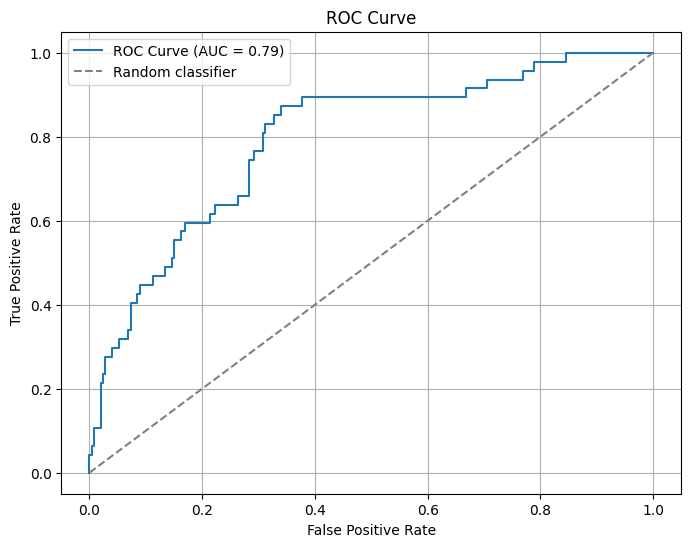

In [25]:
# Obtenir les probabilit√©s de la classe positive
y_scores_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores_test)

# Calculer l'AUC de la ROC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


##### Analyse de la courbe ROC

La courbe ROC pr√©sent√©e ci-dessus mesure la capacit√© du mod√®le √† distinguer les classes **d√©part** et **non-d√©part**.  

‚úÖ **Principaux constats :**
- La courbe ROC s‚Äô√©loigne bien de la diagonale al√©atoire, indiquant que le mod√®le a une capacit√© discriminante.
- La **surface sous la courbe (AUC) est de 0,79**, ce qui refl√®te une performance globale correcte.

‚ö†Ô∏è **√âl√©ments de prudence :**
- La courbe ROC n‚Äôindique pas si le mod√®le est meilleur pour limiter les **faux positifs** (pr√©dire un d√©part √† tort) ou les **faux n√©gatifs** (ne pas d√©tecter un d√©part).
- Comme les donn√©es sont d√©s√©quilibr√©es (beaucoup moins de d√©parts que de non-d√©parts), la ROC peut donner une impression **trop optimiste de la qualit√© pr√©dictive**.
  
‚û°Ô∏è **Prochaines √©tapes :**
C‚Äôest pourquoi nous allons maintenant analyser la **courbe Pr√©cision‚ÄìRappel**, plus adapt√©e √† l‚Äô√©valuation des mod√®les sur des jeux de donn√©es d√©s√©quilibr√©s.


### Courbes Pr√©cision-Rappel et F2-score vs seuil

Seuil optimal : 0.2366
Meilleur F2-score : 0.6550


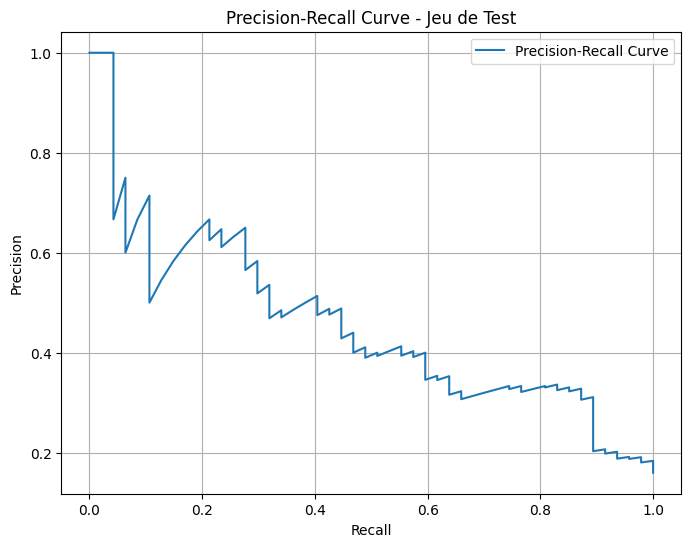

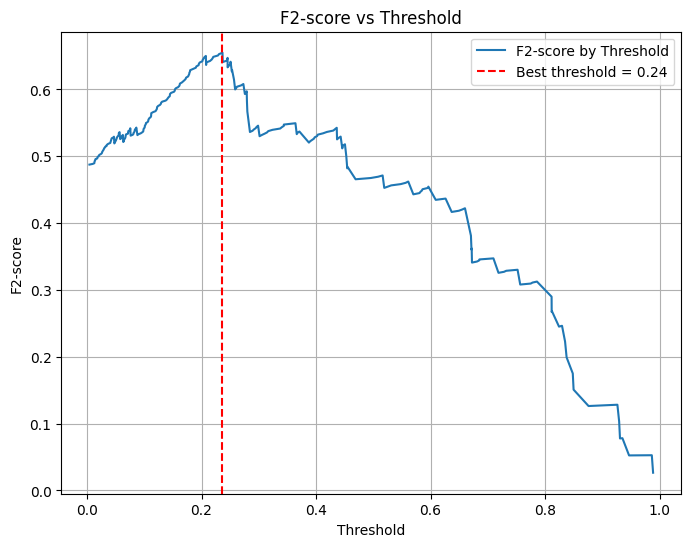

In [26]:
# Obtenir les probabilit√©s de la classe positive
y_scores_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores_test)

# Calculer le F2-score pour chaque seuil
f2_scores = []
for thresh in thresholds:
    preds = (y_scores_test >= thresh).astype(int)
    score = fbeta_score(y_test, preds, beta=2)
    f2_scores.append(score)

# Trouver le seuil optimal
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]
best_f2 = f2_scores[best_idx]

print(f"Seuil optimal : {best_threshold:.4f}")
print(f"Meilleur F2-score : {best_f2:.4f}")

# Tracer la courbe Pr√©cision‚ÄìRappel
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Jeu de Test")
plt.legend()
plt.grid(True)
plt.show()

# Tracer la courbe F2-score en fonction du seuil
plt.figure(figsize=(8,6))
plt.plot(thresholds, f2_scores, label="F2-score by Threshold")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F2-score")
plt.title("F2-score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

##### Analyse de la courbe Pr√©cision‚ÄìRappel

La courbe Pr√©cision‚ÄìRappel permet d‚Äô√©valuer la performance du mod√®le sur un jeu de donn√©es **d√©s√©quilibr√©**, en se concentrant sur la capacit√© √† d√©tecter les d√©parts.

‚úÖ **Principaux constats :**
- La pr√©cision diminue progressivement lorsque le rappel augmente, ce qui est un comportement attendu.
- Pour des valeurs de rappel faibles (<0,2), la pr√©cision peut d√©passer **0,8**, traduisant que lorsqu‚Äôon d√©tecte peu de d√©parts, ils sont souvent corrects.
- Lorsque le rappel d√©passe **0,5**, la pr√©cision chute autour de **0,4**, ce qui signifie que plus on cherche √† capter de cas positifs, plus on g√©n√®re de faux positifs.

‚ö†Ô∏è **Limites et interpr√©tation :**
- Cette courbe met en √©vidence un compromis clair entre **pr√©cision** (qualit√© des alertes) et **rappel** (couverture des d√©parts).
- Pour un usage op√©rationnel (ex. ciblage des salari√©s √† risque), il sera crucial de choisir un seuil adapt√© en fonction de la priorit√© :
  - **Minimiser les faux positifs** (√©viter d‚Äôalerter inutilement)
  - ou **maximiser le rappel** (ne rater aucun d√©part).

**Synth√®se :**
- La performance est correcte mais montre que le mod√®le a des limites d√®s qu‚Äôon souhaite capturer un grand nombre de d√©parts.
- Cette analyse compl√®te la ROC et fournit une vision plus r√©aliste dans le contexte des classes d√©s√©quilibr√©es.

##### Analyse de la courbe F2-Score vs Seuil

Cette courbe montre comment le **F2-score** √©volue en fonction du seuil de d√©cision appliqu√© aux probabilit√©s pr√©dites.

‚úÖ **Principaux constats :**
- Le **F2-score maximal (~0,65)** est obtenu pour un seuil autour de **0,24** (ligne rouge).
  - Ce seuil favorise le rappel par rapport √† la pr√©cision, ce qui est coh√©rent avec l‚Äôutilisation du F2-score (pond√®re davantage le rappel).
- Pour des seuils plus √©lev√©s (>0,4), le F2-score baisse progressivement jusqu‚Äô√† atteindre des valeurs proches de z√©ro.
  - Cela indique que fixer un seuil trop strict conduit √† manquer beaucoup de d√©parts.

‚ö†Ô∏è **Interpr√©tation et pr√©cautions :**
- Le seuil optimal ici est bien **inf√©rieur √† 0,5**, ce qui montre que le mod√®le a tendance √† produire des probabilit√©s faibles m√™me pour les cas positifs.
- Ce seuil sera choisi en coh√©rence avec les priorit√©s m√©tier :
  - **Maximiser le rappel** (ne pas rater de d√©parts) tout en conservant une pr√©cision acceptable.
- Un seuil bas entra√Ænera un nombre plus √©lev√© de faux positifs, qu‚Äôil faudra expliquer et justifier lors de la mise en production.

**Synth√®se :**
- La courbe permet de s√©lectionner un seuil adapt√© aux objectifs (sensibilit√© prioritaire).
- La d√©cision finale doit √™tre align√©e avec la capacit√© op√©rationnelle √† traiter les alertes g√©n√©r√©es.



## Evaluation des performances finales

In [27]:
# G√©n√©rer les pr√©dictions finales avec le seuil optimal
y_pred_final = (y_scores_test >= best_threshold).astype(int)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_final)
print("Matrice de confusion :")
print(cm)

# Afficher le rapport de classification
report = classification_report(
    y_test,
    y_pred_final,
    target_names=["Non-d√©part", "D√©part"],
    digits=3
)
print("Rapport de classification :")
print(report)

f2 = fbeta_score(y_test, y_pred_final, beta=2)
print(f"F2-score final : {f2:.3f}")

Matrice de confusion :
[[163  84]
 [  6  41]]
Rapport de classification :
              precision    recall  f1-score   support

  Non-d√©part      0.964     0.660     0.784       247
      D√©part      0.328     0.872     0.477        47

    accuracy                          0.694       294
   macro avg      0.646     0.766     0.630       294
weighted avg      0.863     0.694     0.735       294

F2-score final : 0.655


##### Analyse de la matrice de confusion et du rapport de classification

‚úÖ **Principaux constats :**
- **Non-d√©part (classe majoritaire) :**
  - Tr√®s bonne pr√©cision (**0,96**) : peu de faux positifs.
  - Rappel plus faible (**0,66**) : environ un tiers des non-d√©parts sont mal class√©s.

- **D√©part (classe minoritaire) :**
  - Rappel √©lev√© (**0,87**) : la plupart des d√©parts sont d√©tect√©s.
  - Pr√©cision faible (**0,33**) : beaucoup de faux positifs.
  - F1-score modeste (**0,48**) : √©quilibre imparfait entre pr√©cision et rappel.

‚úÖ **Performance globale :**
- **Accuracy : 0,69** (mais peu informative en contexte d√©s√©quilibr√©).
- **Macro moyenne F1 : 0,63** (moyenne non pond√©r√©e des classes).
- **F2-score final : 0,655**, confirmant la priorit√© donn√©e au rappel.

‚ö†Ô∏è **Points d‚Äôattention :**
- La performance sur la classe "D√©part" d√©pend fortement du rappel, au d√©triment de la pr√©cision.
- Le nombre √©lev√© de faux positifs (84) n√©cessitera une gestion attentive si le mod√®le est utilis√© en production.
- Le choix du seuil refl√®te une strat√©gie assum√©e : **mieux vaut alerter que rater un d√©part**.

**Synth√®se :**
- Le mod√®le capte bien les d√©parts, avec un rappel satisfaisant.
- La pr√©cision reste limit√©e, ce qui implique une communication claire sur le taux de fausses alertes.


## Feature Importance Native XGBoost

In [28]:
pd.set_option('display.max_rows', None)

# Extraire l'estimateur final depuis le pipeline optimis√©
model_xgb = grid_search.best_estimator_.named_steps["modele_utilise"]

# Extraire les importances
importances = model_xgb.feature_importances_

# R√©cup√©rer les noms de colonnes finales avec une m√©thode robuste
preprocessor = grid_search.best_estimator_.named_steps["preprocessing"]

feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    # Ignore le 'drop'
    if transformer == "drop":
        continue
    # Prend les colonnes telles quelles si passthrough
    if transformer == "passthrough":
        feature_names.extend(columns)
        continue
    # Cas d'un pipeline imbriqu√©
    if hasattr(transformer, "named_steps"):
        last_step = list(transformer.named_steps.values())[-1]
        if hasattr(last_step, "get_feature_names_out"):
            names = last_step.get_feature_names_out()
        else:
            names = columns
    else:
        if hasattr(transformer, "get_feature_names_out"):
            names = transformer.get_feature_names_out()
        else:
            names = columns
    feature_names.extend(names)

# Cr√©er un DataFrame tri√©
import pandas as pd

df_importances = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Afficher le tableau
print(df_importances)


                                       Variable  Importance
13              interaction_distance_heures_sup    0.034166
11          interaction_satisfaction_anciennete    0.034030
9                                    age_revenu    0.032518
22                       poste_Cadre Commercial    0.032486
19                       departement_Consulting    0.030889
16                    statut_marital_Divorc√©(e)    0.030698
6                      nombre_participation_pee    0.029656
40                    tranche_age_Interm√©diaire    0.029487
26                poste_Repr√©sentant Commercial    0.027505
44          satisfaction_employee_environnement    0.026670
10                         satisfaction_moyenne    0.026341
14                         surmenage_transports    0.026153
23                             poste_Consultant    0.025930
5                 annes_sous_responsable_actuel    0.025917
51                        frequence_deplacement    0.024722
29                              poste

##### Analyse importance des variables (importance native)

- Les variables les plus importantes sont :
  - **interaction_distance_heures_sup** et **interaction_satisfaction_anciennete** (~0,034).
  - **age_revenu** et plusieurs variables li√©es au **poste occup√©** et au **d√©partement** (~0,03).
- D‚Äôautres variables comportementales et de satisfaction apparaissent dans le haut du classement (**satisfaction_moyenne**, **surmenage_transports**).
- Plusieurs variables ont une importance nulle, notamment :
  - **heures_supplementaires_binaire**, certaines **tranches d‚Äô√¢ge**, et le **domaine d‚Äô√©tude RH**.
- Ces r√©sultats refl√®tent surtout l‚Äôimpact structurel du mod√®le sur les splits des arbres.

**Synth√®se :**
Cette importance native oriente la compr√©hension des principaux facteurs, mais sera compl√©t√©e par l‚Äôanalyse par permutation plus robuste.


## Permutation Importance

In [29]:
# Calculer l'importance par permutation
result = permutation_importance(
    grid_search.best_estimator_,
    X_test,
    y_test,
    scoring=f2_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Utiliser directement les colonnes originales de X_test
feature_names_perm = X_test.columns

# V√©rification
print("Nombre de colonnes X_test:", len(feature_names_perm))
print("Nombre d'importances:", len(result.importances_mean))

# Cr√©er le DataFrame
importances_perm_df = pd.DataFrame({
    "Variable": feature_names_perm,
    "Importance moyenne": result.importances_mean,
    "√âcart-type": result.importances_std
}).sort_values(by="Importance moyenne", ascending=False)

# Afficher
print(importances_perm_df)

Nombre de colonnes X_test: 42
Nombre d'importances: 42
                                     Variable  Importance moyenne  √âcart-type
36            interaction_distance_heures_sup            0.093462    0.037858
41                       surmenage_transports            0.060577    0.025441
10                   nombre_participation_pee            0.035861    0.034731
28                                tranche_age            0.022831    0.016010
1                                       genre            0.011892    0.011587
33        interaction_satisfaction_anciennete            0.010824    0.030885
7                     annee_experience_totale            0.008481    0.021599
9                 annees_dans_le_poste_actuel            0.007431    0.016145
27             distance_domicile_travail_qcut            0.005407    0.017023
2                              revenu_mensuel            0.003193    0.027160
15                      frequence_deplacement            0.002524    0.029683
29      

##### Synth√®se globale des importances (native et permutation)

‚úÖ **Variables les plus contributives :**
- Les deux m√©thodes confirment l‚Äôimportance de :
  - **interaction_distance_heures_sup** (native : top 1, permutation : plus forte importance).
  - **surmenage_transports** (importante en permutation, bien class√©e en native).
- Ces variables traduisent le lien entre contraintes de d√©placement, surcharge et d√©part.

‚úÖ **Diff√©rences notables entre m√©thodes :**
- La permutation valorise beaucoup plus **nombre_participation_pee** et **tranche_age**.
- Des variables importantes en importance native (ex. `age_revenu`, certaines modalit√©s de poste) apparaissent avec des importances n√©gatives ou nulles en permutation.
  - Cela indique qu‚Äôelles structurent les splits mais apportent moins d‚Äôam√©lioration de la performance globale.

‚úÖ **Variables avec importance nulle ou n√©gative :**
- Plusieurs variables affichent des valeurs nulles ou n√©gatives en permutation :
  - **revenu_stable**, **heures_supplementaires_binaire**, **satisfaction_employee**, etc.
- Cela peut signifier qu‚Äôelles n‚Äôapportent pas d‚Äôinformation pr√©dictive apr√®s prise en compte des autres variables.

**Synth√®se :**
- L‚Äôimportance par permutation est g√©n√©ralement plus fiable pour juger la **vraie contribution pr√©dictive**.
- La convergence sur certaines variables-cl√©s renforce leur cr√©dibilit√© (interactions et surcharge).
- Les autres variables devront √™tre valid√©es ou √©cart√©es selon leur int√©r√™t m√©tier

## Interpr√©tation SHAP

### Importance globale

In [30]:
# Extraire le mod√®le XGBoost depuis le pipeline
model_xgb = grid_search.best_estimator_.named_steps["modele_utilise"]

# Transformer X_test avec le preprocessor
X_test_transformed = grid_search.best_estimator_.named_steps["preprocessing"].transform(X_test)

# Cr√©er l'explainer sp√©cifique √† XGBoost
explainer = shap.TreeExplainer(model_xgb)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_test_transformed)

In [31]:
preprocessor = grid_search.best_estimator_.named_steps["preprocessing"]
feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if transformer == "drop":
        continue
    if transformer == "passthrough":
        feature_names.extend(columns)
        continue
    if hasattr(transformer, "named_steps"):
        last_step = list(transformer.named_steps.values())[-1]
        if hasattr(last_step, "get_feature_names_out"):
            names = last_step.get_feature_names_out()
        else:
            names = columns
    else:
        if hasattr(transformer, "get_feature_names_out"):
            names = transformer.get_feature_names_out()
        else:
            names = columns
    feature_names.extend(names)

In [32]:
# V√©rifier la forme des shap_values
print(type(shap_values))
if isinstance(shap_values, list) and len(shap_values) == 2:
    # Pour la classe positive
    shap_values_class1 = shap_values[1]
else:
    # Si shap_values est un seul array
    shap_values_class1 = shap_values

df_shap = pd.DataFrame(
    shap_values_class1,
    columns=feature_names
)

# Aper√ßu des valeurs SHAP
print(df_shap.head())

df_shap.to_csv("shap_values_class1.csv", index=False)

<class 'numpy.ndarray'>
   revenu_mensuel       age  annee_experience_totale  \
0        0.319248  0.009519                -0.109557   
1        0.259395 -0.040757                 0.027772   
2       -0.547636  0.024096                 0.127719   
3       -0.644328  0.053662                -0.545753   
4       -0.123719 -0.177177                -0.143315   

   annees_dans_l_entreprise  annees_dans_le_poste_actuel  \
0                  0.020603                    -0.010232   
1                  0.072423                    -0.022969   
2                 -0.077024                     0.042212   
3                  0.054351                    -0.088292   
4                  0.027017                    -0.017640   

   annes_sous_responsable_actuel  nombre_participation_pee  ratio_stagnation  \
0                       0.207232                 -0.463099          0.120843   
1                      -0.050602                 -0.243840         -0.031403   
2                       0.059827      

In [33]:
df_shap.abs().mean().sort_values(ascending=False)

interaction_distance_heures_sup                0.456034
nombre_participation_pee                       0.430460
age_revenu                                     0.369817
satisfaction_moyenne                           0.342833
interaction_satisfaction_anciennete            0.314131
taux_de_formation                              0.237379
revenu_mensuel                                 0.236956
frequence_deplacement                          0.220683
poste_Assistant de Direction                   0.212758
note_evaluation_precedente                     0.204256
tranche_age_Interm√©diaire                      0.188123
surmenage_transports                           0.177441
annee_experience_totale                        0.161015
satisfaction_employee_environnement            0.148140
ratio_sous_responsable                         0.145724
ratio_stagnation                               0.137913
age                                            0.124204
satisfaction_employee_nature_travail           

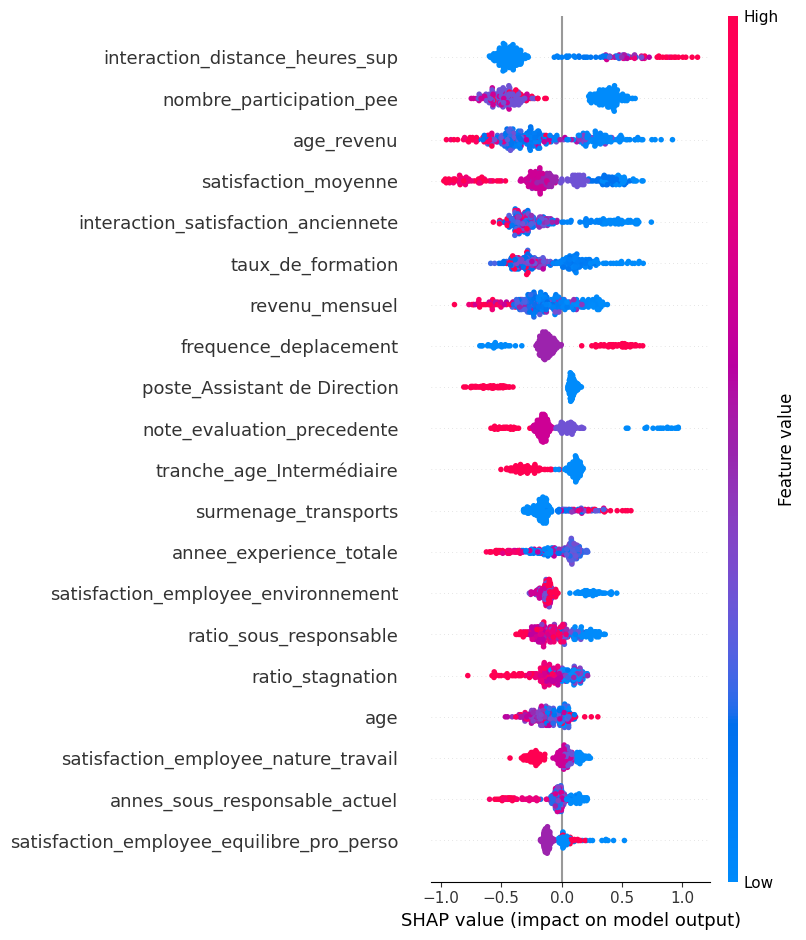

In [34]:
# Beeswarm plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

##### Analyse des importances SHAP (valeurs absolues)

‚úÖ **Variables les plus contributives :**
- **interaction_distance_heures_sup** (0,456) est la variable avec l‚Äôimpact moyen le plus √©lev√©.
- **nombre_participation_pee** (0,430) et **age_revenu** (0,370) confirment leur poids pr√©dictif important.
- **satisfaction_moyenne** (0,343) et **interaction_satisfaction_anciennete** (0,314) occupent aussi une place cl√©.
  - Ces variables traduisent des dimensions combin√©es de surcharge, stabilit√© et satisfaction.

‚úÖ **Variables secondaires mais significatives :**
- **taux_de_formation**, **revenu_mensuel**, et **frequence_deplacement** apportent une contribution notable (0,22‚Äì0,24).
- Certaines modalit√©s de poste (**Assistant de Direction**, **Consultant**, **Cadre Commercial**) apparaissent √©galement avec des valeurs SHAP moyennes >0,07.

‚úÖ **Variables √† impact faible ou nul :**
- De nombreuses variables affichent des valeurs SHAP tr√®s basses (<0,02), voire nulles :
  - **heures_supplementaires_binaire**, **tranches d‚Äô√¢ge Junior/Senior**, **Ressources Humaines**.
  - Leur apport explicatif est n√©gligeable.

**Synth√®se :**
- L‚Äôanalyse SHAP compl√®te les autres m√©thodes (importance native, permutation) en confirmant le r√¥le dominant :
  - Des variables d‚Äô**interaction et surcharge**.
  - De la **satisfaction** et de l‚Äô**anciennet√© combin√©e au revenu**.
- La convergence entre plusieurs approches renforce la confiance dans la s√©lection de ces variables comme facteurs cl√©s.


### Quelques exemples issues des deux classes

In [35]:
# Les pr√©dictions finales avec le seuil optimal
y_pred_final = (y_scores_test >= best_threshold).astype(int)

# Cr√©er un DataFrame r√©capitulatif
df_preds = pd.DataFrame({
    "R√©el": y_test.values,
    "Pr√©dit": y_pred_final,
    "Probabilit√©": y_scores_test
})

# Afficher quelques exemples
print(df_preds.head(10))

   R√©el  Pr√©dit  Probabilit√©
0     0       1     0.636802
1     0       0     0.081135
2     0       0     0.106882
3     0       0     0.012855
4     1       1     0.452787
5     0       0     0.105807
6     0       0     0.079839
7     0       0     0.049791
8     0       0     0.041856
9     0       1     0.531200


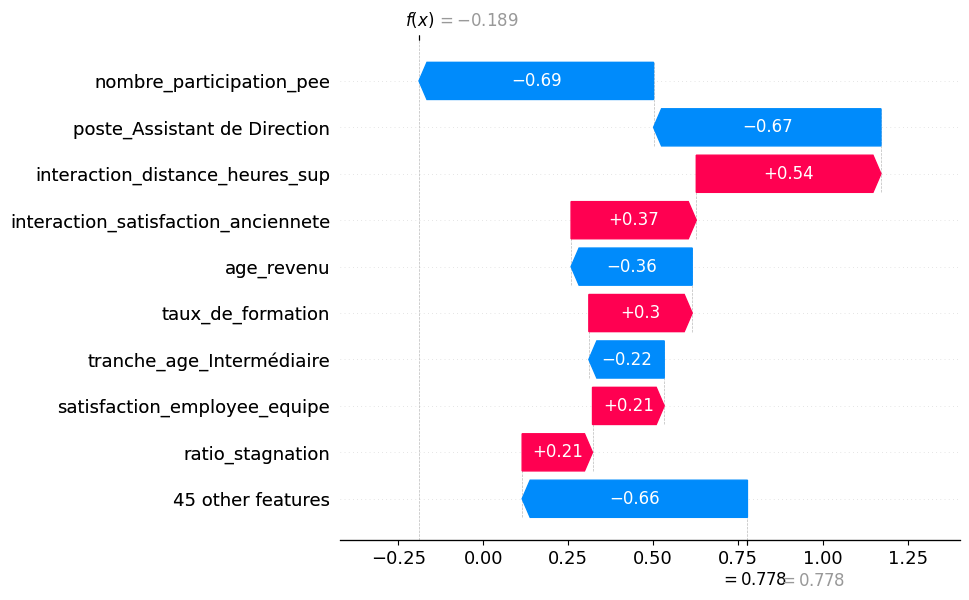

In [36]:
# Observation 4 : vrai positif
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[4,:],
    feature_names=feature_names
)

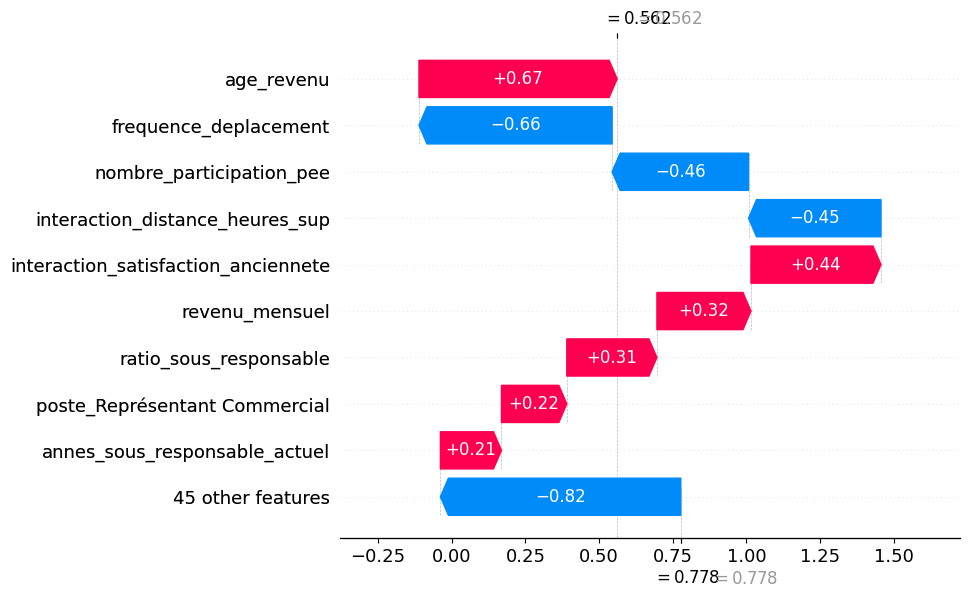

In [37]:
# Observation 0 : faux positif
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0,:],
    feature_names=feature_names
)

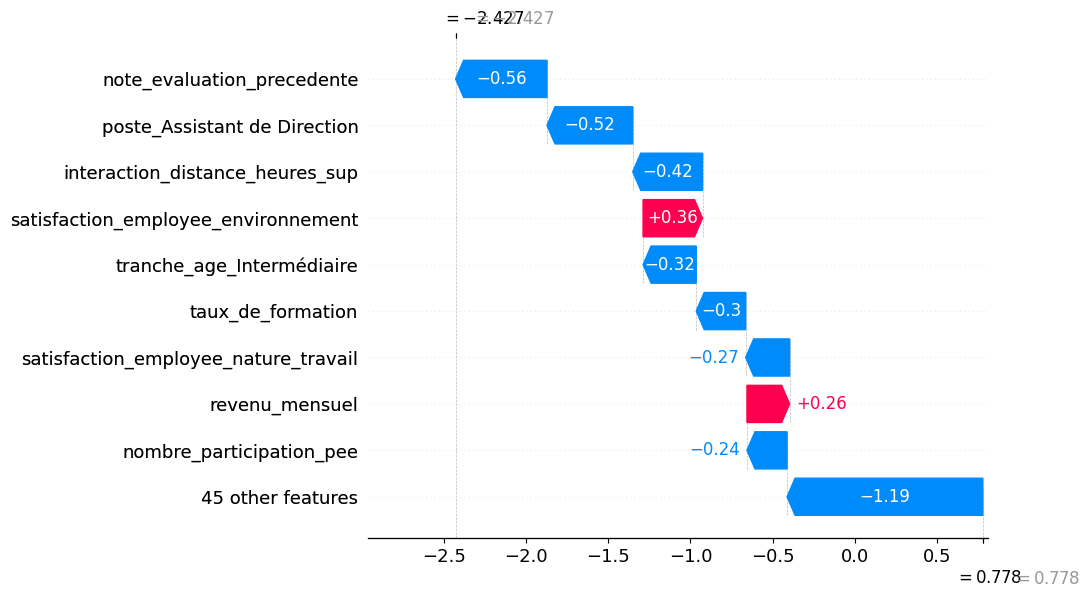

In [38]:
# Observation 1 : vrai n√©gatif
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[1,:],
    feature_names=feature_names
)

# Synth√®se globale de la classification du turnover

##### üéØ Synth√®se finale du projet

---

##### ‚úÖ Performances globales du mod√®le

- **Mod√®le retenu :**
  - XGBoostClassifier
  - Hyperparam√®tres finaux :
    - `max_depth=3`
    - `learning_rate=0.1`
    - `subsample=0.5`
    - `scale_pos_weight=5`
- **Seuil optimal choisi :** ‚âà0.24
- **Scores en test :**
  - Recall classe D√©part : **0.87**
  - Precision classe D√©part : **0.33**
  - F2-score final : **0.655**
- **Interpr√©tation :**
  - Le mod√®le privil√©gie la d√©tection des d√©parts (rappel √©lev√©).
  - Il accepte un nombre important de faux positifs.
  - Ce compromis est assum√© compte tenu de l‚Äôobjectif m√©tier.

---

##### ‚úÖ Facteurs contributifs identifi√©s

**1Ô∏è‚É£ Importance native**
- Variables dominantes dans les arbres :
  - `interaction_distance_heures_sup`
  - `surmenage_transports`
  - `age_revenu`
- Ces variables structurent la construction des splits.

**2Ô∏è‚É£ Importance par permutation**
- Variables les plus contributives :
  - `interaction_distance_heures_sup`
  - `surmenage_transports`
  - `nombre_participation_pee`
- Certaines variables jug√©es importantes en native apparaissent faibles en permutation.

**3Ô∏è‚É£ SHAP valeurs globales**
- Variables √† impact moyen √©lev√© :
  - `interaction_distance_heures_sup`
  - `nombre_participation_pee`
  - `satisfaction_moyenne`
  - `age_revenu`
- Les effets varient selon les individus.

---

##### üß≠ Interpr√©tation critique

- Les trois m√©thodes convergent sur un constat :
  **le mod√®le capte un signal dispers√©, sans variable unique d√©terminante.**
- Ce constat est fr√©quent en RH :
  - Les causes de d√©part sont multifactorielles.
  - Certaines dimensions (climat, motivations personnelles) ne figurent pas dans le dataset.
- Les corr√©lations sont faibles √† mod√©r√©es.

---

##### üß≠ Recommandations m√©tier prudentes

1Ô∏è‚É£ **Surveiller les signaux faibles**
   - Contraintes et surcharge (`interaction_distance_heures_sup`, `surmenage_transports`)
   - Indicateurs de stabilit√© (`revenu_mensuel`, `age_revenu`)
   - Participation aux dispositifs collectifs (`nombre_participation_pee`)

2Ô∏è‚É£ **Compl√©ter l‚Äôanalyse par des donn√©es terrain**
   - Entretiens de d√©part
   - Enqu√™tes d‚Äôengagement

3Ô∏è‚É£ **Renforcer le feature engineering**
   - Int√©grer des √©volutions temporelles et des interactions suppl√©mentaires.

4Ô∏è‚É£ **Ne pas surinterpr√©ter**
   - Les pr√©dictions sont une aide √† la r√©flexion, non un jugement d√©finitif.

---

##### üìù Conclusion

Le projet montre :
- La faisabilit√© d‚Äôun mod√®le pr√©dictif reproductible.
- La capacit√© √† identifier partiellement les profils √† risque.
- La n√©cessit√© de combiner approche quantitative et vision qualitative.

**En synth√®se :**
> Ce mod√®le est un point de d√©part utile, mais doit √™tre compl√©t√© par une r√©flexion plus large sur les leviers d‚Äôengagement et de fid√©lisation.


## Export du pipeline

In [40]:
# Export du pipeline
joblib.dump(
    grid_search.best_estimator_,
    "C:/Users/Fab/Documents/P5_D√©ployez_un_mod√®le_de_Machine_Learning/app/models/pipeline.joblib"
)


['C:/Users/Fab/Documents/P5_D√©ployez_un_mod√®le_de_Machine_Learning/app/models/pipeline.joblib']